# Latent causal discovery with TIGRAMITE

TIGRAMITE is a time series analysis python module. It allows to reconstruct causal graphical models from discrete or continuously-valued time series based on the PCMCI framework and create high-quality plots of the results.

This tutorial explains the **Latent-PCMCI (LPCMCI) algorithm**, which is implemented as the function `LPCMCI.run_lpcmci`. In contrast to the [PCMCI](https://github.com/jakobrunge/tigramite/blob/master/tutorials/tigramite_tutorial_basics.ipynb) and [PCMCIplus](https://github.com/jakobrunge/tigramite/blob/master/tutorials/tigramite_tutorial_pcmciplus.ipynb) algorithms, respectively implemented as `PCMCI.run_pcmci` and `PCMCI.run_pcmciplus`, LPCMCI allows for unobserved (aka latent) time series.

**Note:**
This method is still experimental since the default settings of hyperparameters are still being fine-tuned. Feedback on this matter is kindly appreciated.

---
**Publication on LPCMCI:**
Gerhardus, Andreas and Runge, Jakob (2020). High-recall causal discovery for autocorrelated time series with latent confounders. In Larochelle, H., Ranzato, M., Hadsell, R., Balcan, M. F., and Lin, H., editors, *Advances in Neural Information Processing Systems*, volume 33, pages 12615–12625. Curran Associates, Inc. [https://proceedings.neurips.cc/paper/2020/file/94e70705efae423efda1088614128d0b-Paper.pdf](https://proceedings.neurips.cc/paper/2020/file/94e70705efae423efda1088614128d0b-Paper.pdf).

---

The structure of this tutorial is as follows:
1. Section 1 explains the interpretation of the causal graphical models that are being learned by LPCMCI.
2. Section 2 gives an introduction into how LPCMCI works and explains its essential parameters and output.
3. Section 3 explains the practical use of LPCMCI by showing an example application on synthetic data.

In [1]:
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline     

import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys
from tigramite import plotting as tp
from tigramite.lpcmci import LPCMCI
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
# from tigramite.independence_tests.gpdc import GPDC
# from tigramite.independence_tests.cmiknn import CMIknn
# from tigramite.independence_tests.cmisymb import CMIsymb

## 1 Structural causal processes and their graphical representation

We are interested in learning the causal structure underlying complex dynamical systems. The corresponding time series $\mathbf{V}_t=(V^1_t,\ldots,V^N_t)$ is assumed to follow a structural causal process, i.e., to be of the form

$$\begin{align} \label{eq:causal_model} V^j_t &= f_j\left(\mathcal{P}(V^j_t),\,\eta^j_t\right) \end{align}$$

where $f_j$ is some arbitrary measurable function with non-trivial dependencies on all its arguments, $\eta^j_t$ represents mutually ($i\neq j$) and serially ($t'\neq t$) independent dynamical noise, and $\mathcal{P}(V^j_t) \subset \mathbf{V}^-_{t+1}=(\mathbf{V}_{t}, \mathbf{V}_{t-1},\ldots){\setminus} \{V^j_t\}$. Imporantly, the equation is asserted to have causal meaning in the sense that it represents the physical mechanism by which the value of $V^j_t$ is determined from the values of variables in $\mathcal{P}(V^j_t)$ together with the value of the dynamical noise $\eta^j_t$.$^a$ This is why variables variables in $\mathcal{P}(V^j_t)$ are referred to as *causal parents* of $V^j_t$. We further require that $V^i_{t-\tau} \in \mathcal{P}(V^j_{t})$ if and only if $V^i_{t-\tau - \Delta t} \in \mathcal{P}(V^j_{t-\Delta t})$, a property referred to as *causal stationarity*, and that there are no cyclic causal relationships (both these properties have an intuitive graphical meaning, see subsection 1.1 below).

The goal of LPCMCI is to learn the time series DPAG of the data-generating structural causal process, which is a graph that represents partial knowledge of the causal ancestral relationships among only the observed variables. These graphs are introduced and explained in the remainder of this section.

Footnotes:\
$^a$For a more detailed explanation of this point we refer to the literature on structural causal models, see e.g. the textbooks [1] and [2] (the references are given at the bottom of this notebook).

### 1.1 Time series DAGs

The causal *parentships* specified by a structural causal process can conveniently be represented by a directed acyclic graph (DAG) $\mathcal{G}$ that
1. has one vertex (aka node) per variable $V^j_t$ and
2. an edge (aka link) $V^i_{t-\tau} {\rightarrow} V^j_t$ if and only if $V^i_{t-\tau} \in \mathcal{P}(V^j_t)$.

It is acyclic precisely because by assumption there are no cyclic causal relationships, and its structure is repetitive in time due to the causal stationarity. In other tutorials in TIGRAMITE $\mathcal{G}$ is also referred to as *time series graph*.

An edge $V^i_{t-\tau} {\rightarrow} V^j_t$ with $\tau > 0$ is referred to as *lagged* and the integer $\tau$ is its *lag*. Edges $V^i_{t} {\rightarrow} V^j_t$ are called *contemporaneous*. The *order* of a process, denoted by $p_{\text{ts}}$, is the maximum lag.

For illustration, here and in the subsequent discussions, we consider the following linear structural causal process of order $p_{\text{ts}}= 2$ with four component time series as a running example:

$$
\begin{align}
V^1_t &= 0.9 V^1_{t-1} + 0.6 V^2_{t} + \eta^1_t\\
V^2_t &= \eta^2_t \\
V^3_t &= 0.9 V^3_{t-1} + 0.4 V^2_{t-1} + \eta^3_t\\
V^4_t &= 0.9 V^4_{t-1} - 0.4 V^3_{t-2} + \eta^4_T
\end{align}
$$

The following figure shows the associated time series DAG $\mathcal{G}$:

<img src="figures/ts_DAG.png" width=300 height=300 />

The horizontal dots on the left and right indicate that this graph in principle extends to the infinity past and future. However, due to the repetitive structure as imposed by causal stationarity it is sufficient to restrict to a time window at least as large as $[t-p_{\text{ts}}, t]$ (for the above example this means it would have been sufficient to show one time step less). By convention we only draw those edges that are fully contained within the shown time window: For example, the edge $V^1_{t-1} {\rightarrow} V^3_{t+1}$ is not drawn despite $V^1_{t-1}$ being in the shown time window $[t-3, t]$ because $V^3_{t+1}$ is outside this time window.

### 1.2 Time series DMAGs

The setting of LPCMCI, which distinguishes it from PCMCI and PCMCIplus, is that a subset of the component time series is allowed to be unobserved. In other words: The set of component time series $V^1, \ldots, V^N$ splits into a set of observed time series $X^1, \ldots, X^{N_X}$ with $N_X \geq 1$ and a set of unobserved time series $L^1, \ldots, L^{N_L}$ with $N_L \geq 0$ and $N = N_X + N_L$.

This raises the question as how to represent the causal relationships of the underlying process in a graph with vertices only for the observed variables. One approach, which LPCMCI is based on, is to employ *directed maximal ancestral graphs (DMAGs)*. These are a type of directed mixed graphs and, thus, can have directed edges $X {\rightarrow} Y$ and bidirected edges $X {\leftrightarrow} Y$. They are a specialization of the yet more general class of maximal ancestral graphs (MAGs) introduced in [3], which in addition allow to represent selection bias. For LPCMCI, however, the absence of selection bias is assumed.

The basic idea is as follows:\
To a given DAG $\mathcal{G}$ with a given subset of unobserved variables one can associate a unique DMAG $\mathcal{M}(\mathcal{G})$ over the observed variables that has the following properties:

1. **Adjacencies:**\
There is an edge between vertices $X$ and $Y$, i.e., $X {\rightarrow} Y$ or $X {\leftarrow} Y$ or $X {\leftrightarrow} X$, if and only if the information flow between them cannot be blocked by conditioning on any subset of observed variables, i.e., if and only if there is no subset of observed variables conditional on which $X$ and $Y$ become independent.
2. **Edge types:**
    1. $X {\rightarrow} Y$ implies that in $\mathcal{G}$ there is a directed path from $X$ to $Y$. Because $\mathcal{G}$ is acyclic, this further implies that there is no directed path from $Y$ to $X$.
    2. $X {\leftrightarrow} Y$ implies that in $\mathcal{G}$ there neither is a directed path from $X$ to $Y$ nor a directed path from $Y$ to $X$.
    
Since the DAG $\mathcal{G}$ carries causal meaning, in the sense that a directed edge signifies causal parentship, also the associated DMAG $\mathcal{M}(\mathcal{G})$ carries causal meaning:
1. $X {\rightarrow} Y$ says that
    1. $X$ is a (potentially indirect) cause of $Y$
    2. $Y$ does not cause $X$
2. $X {\leftrightarrow} Y$ says that
    1. $X$ does not cause $Y$
    2. $Y$ does not cause $X$
    2. $X$ and $Y$ are subject to unobserved confounding, i.e., there is an unobserved variable $Z$ that causes both $X$ and $Y$ (this follows because else there would not be any edge between $X$ and $Y$).

In other words: The DMAG $\mathcal{M}(\mathcal{G})$ represents the *causal ancestral relationships* of the underlying data generating process. The absence and presence of an edge between a pair of variables do, however, not have a straightforward causal interpretation.

In the time series setting considered here one additional aspect comes into play: Not the entire past and future but only a *finite* number of time steps can be observed. This amounts to the choice of an observed time window $[t-\tau_{\text{max}}, t]$, where $\tau_{\text{max}} \geq 0$ is referred to as *maximum considered time lag*.$^a$ Moreover, the repetitive structure of the underyling DAG $\mathcal{G}$ can be used to also impose a repetitive structure on the associated DMAG which is then extrapolated to the time steps outside of the observed time window. As will be explained in more detail in subsection 1.2.2, the resulting DMAG in general depends on the choice of $\tau_{\text{max}}$. For this reason we employ the notation $\mathcal{M}^{\tau_{\text{max}}}(\mathcal{G})$ when specifically referring to the time series setting.

To illustrate the previous discussion, let us return to the running example and say that the component time series $V^2$ is unobserved while $V^1$, $V^3$, and $V^4$ are observed. The corresponding time series DMAG $\mathcal{M}^2(\mathcal{G})$, so with the choice $\tau_{\text{max}} = 2$, is shown on the right-hand-side of the following figure:

<img src="figures/ts_DMAG.png" width=600 height=300 />

Note that the unobserved variable $L^1_{t-1}$ confounds the observed variables $X^1_{t-1}$ and $X^2_t$ by means of the path $X^1_{t-1} {\leftarrow} L^1_{t-1} {\rightarrow} X^2_{t}$. This introduces a dependence between $X^1_{t-1}$ and $X^2_t$ that could only be blocked by conditionig on $L^1_{t-1}$, which cannot be done because $L^1_{t-1}$ is unobserved. Hence, $X^1_{t-1}$ and $X^2_t$ are adjacent in $\mathcal{M}(\mathcal{G})$. Since in $\mathcal{G}$ there neither is a directed path from $X^1_{t-1}$ to $X^2_t$ nor from $X^2_t$ to $X^1_{t-1}$ --- the latter is impossible anyway because there is no causal influence backwards in time as enforced from the outset by restricting the set $\mathcal{P}(V^j_t)$ to the present and past of $V^j_t$ --- the edge between them is bidirected, i.e., $X^1_{t-1} {\leftrightarrow} X^2_t$ in $\mathcal{M}^2(\mathcal{G})$.

Footnotes:\
$^a$Note that $\tau_{\text{max}}$ is NOT equivalent to the process order $p_{\text{ts}}$. The word "considered" in "maximum considered time lag" is supposed to stress the distinction.

#### 1.2.1 More details on the interpretation of DMAGs

The interpretation of DMAGs can sometimes be difficult, especially concerning directed edges. To avoid confusion, we stress what a DMAG $\mathcal{M}(\mathcal{G})$ does NOT entail:
1. A directed edge $X {\rightarrow} Y$ does NOT say that $X$ is a causal parent of $Y$ in $\mathcal{G}$. Rather the directed path from $X$ to $Y$ may contain more than a single edge, i.e., the causal influence of $X$ on $Y$ may be indirect.
2. A directed edge $X {\rightarrow} Y$ does NOT say that $X$ and $Y$ are not subject to unobserved confounding. Rather, in addition to the directed path(s) from $X$ to $Y$ in $\mathcal{G}$ there may be one or more unobserved variables $Z$ that cause both $X$ and $Y$. (However: For certain directed edges it *is* possible to infer the absence of unobserved confounding, see further below in the current subsection 1.2.1).

Both these points are illustrated by the following example, where the left-hand side shows a time series DAG $\mathcal{G}$ and the right-hand side its corresponding time series DMAG $\mathcal{M}^2(\mathcal{G})$:

<img src="figures/ts_DMAG_2.png" width=600 height=300 />

Blocking the dependence between $X^3_{t-1}$ and $X^1_t$ introduced by the path $X^3_{t-1} {\rightarrow} X^2_t {\rightarrow} X^1_t$ requires to condition on $X^2_t$. This, however, introduces a dependence along the path $X^3_{t-1} {\rightarrow} X^2_t {\leftarrow} L^1_{t-1} {\rightarrow} X^1_t$. Therefore, there is no set of observed variables conditional on which $X^3_{t-1}$ and $X^1_t$ become independent and, thus, they are adjacent in $\mathcal{M}^2(\mathcal{G})$. Due to the directed path $X^3_{t-1} {\rightarrow} X^2_t {\rightarrow} X^1_t$ this edge is directed, i.e., $X^3_{t-1} {\rightarrow} X^1_t$ in $\mathcal{M}^2(\mathcal{G})$. Note, however, that $X^3_{t-1}$ is not a causal parent of $X^1_t$ in $\mathcal{G}$, thus illustrating the first point in above list. The second point is illustrated by the edge $X^2_t {\rightarrow} X^1_t$, which is confounded by the unobserved variable $L^1_{t-1}$ through the path $X^2_t {\leftarrow} L^1_{t-1} {\rightarrow} X^1_t$.

However, *under certain conditions it is possible* to infer from $X {\rightarrow} Y$ in $\mathcal{M}(\mathcal{G})$ that $X$ and $Y$ are not subject to unobserved confounding. Such directed edges were termed *visible* in [4]. A sufficient but not necessary condition for visibility is the following:
1. If there is a third variable $Z$ such that $Z {\rightarrow} X {\rightarrow} Y$ or $Z {\leftrightarrow} X {\rightarrow} Y$ in $\mathcal{M}(\mathcal{G})$ and $Z$ and $Y$ are not adjacent in $\mathcal{M}(\mathcal{G})$, then the edge $X {\rightarrow} Y$ is visible, i.e., $X$ and $Y$ are not subject to unobserved confounding.

Note that for the edge $X^2_{t} {\rightarrow} X^1_t$ in the previous example this condition is indeed not met.

#### 1.2.2 Effect of the maximum considered time lag $\tau_{\text{max}}$

As mentioned above, the time series DMAG $\mathcal{M}^{\tau_{\text{max}}}(\mathcal{G})$ can depend on the choice of the maximum considered time lag $\tau_{\text{max}}$. To illustrate this, the right-hand side of the following figure shows the time series DMAG $\mathcal{M}^1(\mathcal{G})$, so for $\tau_{\text{max}} = 1$, associated to our running example.

<img src="figures/ts_DMAG_a.png" width=600 height=300 />

Compare this with the corresponding time series DMAG $\mathcal{M}^2(\mathcal{G})$, which is depicted in section 1.2 before subsection 1.2.1. One difference is that in $\mathcal{M}^1(\mathcal{G})$ there is no edge between $X^2_{t-2}$ and $X^3_t$, while in $\mathcal{M}^2(\mathcal{G})$ there is $X^2_{t-2} {\rightarrow} X^3_t$. The reason is clear: Since $\mathcal{M}^1(\mathcal{G})$ is based on an observed time window $[t-\tau_{\text{max}}, 1] = [t-1, 1]$, it cannot contain edges with a lag larger than $\tau_{\text{max}} = 1$ (conforming with the term "maximum considered time lag"). Moreover, the smaller observed time window leads to more dependence-inducing path that cannot be blocked: First, the path $X^2_{t-1} {\leftarrow} X^2_{t-2} {\rightarrow} X^3_t$ cannot be blocked because this would require to condition on $X^2_{t-2}$. This can, however, not be done because $X^2_{t-2}$ is not within the observed time window $[t-1, t]$. This leads to the edge $X^2_{t-1} {\leftrightarrow} X^3_t$ in $\mathcal{M}^1(\mathcal{G})$. Second and similarly, the path $X^1_{t-1} {\leftarrow} X^1_{t-2} {\leftarrow} X^1_{t-3} {\leftarrow} L^1_{t-3} {\rightarrow} X^2_{t-2} {\rightarrow} X^3_t$ cannot be blocked and hence there is the edge $X^1_{t-1} {\leftrightarrow} X^3_t$ in $\mathcal{M}^1(\mathcal{G})$.

While in this example $\tau_{\text{max}} = 1 < p_{\text{ts}}$, we stress that this condition is not necessary to observe changes in $\mathcal{M}^{\tau_{\text{max}}}(\mathcal{G})$ with $\tau_{\text{max}}$. For more complicated $\mathcal{G}$ there may be difference between $\mathcal{M}^{\tau_{\text{max}}}(\mathcal{G})$ and $\mathcal{M}^{\tau^\prime_{\text{max}}}(\mathcal{G})$ even though $\tau_{\text{max}} \geq p_{\text{ts}}$ and $\tau^\prime_{\text{max}} \geq p_{\text{ts}}$.

### 1.3 Time series DPAGs

At this point the task can be phrased as learning time series DMAGs from observations of the observed time series. LPCMCI does this within the constraint-based approach to causal discovery that utilizes (conditional) independencies in the data, which are tested for by statistical means.

This is, however, an under-determined problem because distinct DMAGs can give rise to the exact same set of (conditional) independencies --- a phenomenon referred to as *Markov equivalence*, which is not specific to DMAGs but rather applies to most probabilistic graphical models. As a consequence, it is without further assumptions in general not possible to uniquely learn the DMAG $\mathcal{M}(\mathcal{G})$ that represents the causal ancestral relationships of the underlying data generating process but rather only a set of candidate time series DMAGs $\mathcal{M}_1, \ldots, \mathcal{M}_m$ that includes $\mathcal{M}(\mathcal{G})$ and which constitutes the *Markov equivalence class* of $\mathcal{M}(\mathcal{G})$. This means that only those features shared by all members of the Markov equivalence class of $\mathcal{M}(\mathcal{G})$ can be learned. These shared features can in turn be represented by *directed partial ancestral graphs (DPAGs)*, which are a specialization$^a$ of partial ancestral graphs (PAGs) that are used to represent Markov equivalence classes of MAGs [5, 6].

The basic idea is as follows:\
All members of the Markov equivalence class agree on adjacencies --- i.e., $X$ and $Y$ are connected by an edge in $\mathcal{M}(\mathcal{G})$ if and only if they are connected by an edge in all members its Markov equivalence class --- but the members may differ with regard to the edge types: For example, if $X {\rightarrow} Y$ is in $\mathcal{M}(\mathcal{G})$ then there could be a member in the Markov equivalence class of $\mathcal{M}(\mathcal{G})$ in which $X {\leftarrow} Y$ or $X {\leftrightarrow} Y$ instead. These ambiguities are represented explicitly by two new edge types, namely partially directed edges $X {\circ\!{\rightarrow}} Y$ and non-directed edges $X {\circ\!{-}\!\circ} Y$. The DPAG $\mathcal{P}(\mathcal{G})$ corresponding to $\mathcal{M}(\mathcal{G})$ is constructed as follows:
1. **Adjacencies:**\
There is an edge between vertices $X$ and $Y$ if and only if there is an edge between them in $\mathcal{M}(\mathcal{G})$.
2. **Edge types:**
    1. $X {\rightarrow} Y$ implies that $X {\rightarrow} Y$ in all members of the Markov equivalence class of $\mathcal{M}(\mathcal{G})$. In particular, $X {\rightarrow} Y$ in $\mathcal{M}(\mathcal{G})$.
    2. $X {\leftrightarrow} Y$ implies that $X {\leftrightarrow} Y$ in all members of the Markov equivalence class of $\mathcal{M}(\mathcal{G})$. In particular, $X {\leftrightarrow} Y$ in $\mathcal{M}(\mathcal{G})$.
    3. $X {\circ\!{\rightarrow}} Y$ implies that all of the following holds:
        1. In all members of the Markov equivalence class of $\mathcal{M}(\mathcal{G})$ there is $X {\rightarrow} Y$ or $X {\leftrightarrow} Y$. In particular, $X {\rightarrow} Y$ or $X {\leftrightarrow} Y$ in $\mathcal{M}(\mathcal{G})$.
        2. There is a member $\mathcal{M}_1$ of the Markov equivalence class of $\mathcal{M}(\mathcal{G})$ such that $X {\rightarrow} Y$ in $\mathcal{M}_1$.
        3. There is a member $\mathcal{M}_2$ of the Markov equivalence class of $\mathcal{M}(\mathcal{G})$ such that $X {\leftrightarrow} Y$ in $\mathcal{M}_2$.
    4. $X {\circ\!{-}\!\circ} Y$ implies that all of the following holds:
        1. There is a member $\mathcal{M}_1$ of the Markov equivalence class of $\mathcal{M}(\mathcal{G})$ such that $X {\rightarrow} Y$ in $\mathcal{M}_1$.
        2. There is a member $\mathcal{M}_2$ of the Markov equivalence class of $\mathcal{M}(\mathcal{G})$ such that $X {\leftarrow} Y$ in $\mathcal{M}_2$.
    
Since $\mathcal{M}(\mathcal{G})$ carries causal meaning, in the sense that its edges signify causal ancestral relationships, also the associated DPAG $\mathcal{P}(\mathcal{G})$ carries causal meaning:
1. $X \rightarrow Y$ says the same as in $\mathcal{M}(\mathcal{G})$, i.e.,
    1. $X$ is a (potentially indirect) cause of $Y$
    2. $Y$ does not cause $X$
2. $X \leftrightarrow Y$ says the same as in $\mathcal{M}(\mathcal{G})$, i.e.,
    1. $X$ does not cause $Y$
    2. $Y$ does not cause $X$
    2. $X$ and $Y$ are subject to unobserved confounding, i.e., there is an unobserved variable $Z$ that causes both $X$ and $Y$.
3. $X {\circ\!{\rightarrow}} Y$ says that
    1. $X$ may or may not cause $Y$
    2. $Y$ does not cause $X$
4. $X {\circ\!{-}\!\circ} Y$ says that
    1. $X$ may or may not cause $Y$
    2. $Y$ may or may not cause $X$

In other words: The DPAG $\mathcal{P}(\mathcal{G})$ represents *partial knowledge of the causal ancestral relationships* of the underlying data generating process. As for $\mathcal{M}(\mathcal{G})$, the absence and presence of an edge between a pair of variables do not have a straightforward causal interpretation.

To illustrate the previous discussion, let us return to our running example. The time series DPAG $\mathcal{P}^{2}(\mathcal{G})$ associated to $\mathcal{M}^{2}(\mathcal{G})$ is shown on the right-hand-side of the following figure:

<img src="figures/ts_DPAG.png" width=800 height=400 />

Footnotes:\
$^a$Specialization to the case of no selection bias.

## 2 LPCMCI: Causal discovery for time series with unobserved confounders

The goal of LPCMCI is to learn time series DPAGs $\mathcal{P}^{\tau_{\text{max}}}(\mathcal{G})$, which as explained in section 1 represent partial knowledge of the causal ancestral relationships of the underlying structural causal process. The value of $\tau_{\text{max}}$ is an input parameter chosen by the user.

This section gives an overview of how the algorithm works. Those eager to get a quick start with applying LPCMCI may skip subsections 2.1 through 2.4 and move to subsections 2.5 and 2.6 directly.

### 2.1 Fundamental basis: The FCI algorithm

The fundamental basis of LPCMCI is the FCI algorithm [7, 8, 6]. This algorithm was developed in the non-temporal setting and learns PAGs, i.e. graphs which represent partial knowledge of causal ancestral relationships in the potential presence of both unobserved confounders and selection bias. The possibility of selection bias can, however, easily be excluded by a few simple modifications. The algorithm works in four steps:
1. **First edge removal phase:**\
Starting from a fully connected graph, where all edges are of the type $X {\circ\!{-}\!\circ} Y$, the algorithm iterates through all pairs of adjacent variables $(X, Y)$ and tests whether $X$ and $Y$ are (conditionally) independent given some subset of other variables. If this is the case, the edge $X {\circ\!{-}\!\circ} Y$ is removed. The tested conditioning sets are subsets of the adjacencies of $X$ and subsets of the adjacencies of $Y$.
2. **Premature collider orientation phase:**\
Based on a certain orientation rule some of the remaining links are turned from $X {\circ\!{-}\!\circ} Y$  into $X {\circ\!{\rightarrow}} Y$ or $X {{\leftarrow}\!\circ} Y$ or $X {\leftrightarrow} Y$.
3. **Second edge remove phase:**\
The algorithm once more iterates through all pairs of adjacent variables $(X, Y)$ and tests whether $X$ and $Y$ are (conditionally) independent given some subset of other variables. This time, however, the tested conditioning sets are subsets not of the adjacencies of $X$ or the adjacencies of $Y$ but rather of larger sets referred to as $\text{Possible-D-Sep}(X, Y)$ and $\text{Possible-D-Sep}(Y, X)$. The identification of these sets rests on the edge type updates made in the previous step.
4. **Rule application phase:**
    1. All remaining edges are turned into $X {\circ\!{-}\!\circ} Y$ (i.e., all edge type updates of step 2. are undone).
    2. The same orientation rule as in step 2. is applied.
    3. A list of other orientation rules, which turn some of the edges into $X {\circ\!{\rightarrow}} Y$ or $X {{\leftarrow}\!\circ} Y$ or $X {\rightarrow} Y$ or $X {\leftarrow} Y$ or $X {\leftrightarrow} Y$, is exhaustively applied.

For another, slightly more precise and detailed explanation of the FCI algorithm see section S2 in the [supplementary material to the paper on LPCMCI](https://papers.nips.cc/paper/2020/file/94e70705efae423efda1088614128d0b-Supplemental.pdf).

Importantly, the constraint-based approach to causal discovery relies on a one-to-one correspondence between (conditional) independencies in the data and the graphical notion of *$d$-separation* in the DAG representing the causal parentships of the data-generating process. That $d$-separations implies the corresponding (conditional) independencies, a property known as the *causal Markov condition*, is already implied by the data being generated according to a structural causal model --- or, in the time series setting considered here, according to a structural causal process. The opposite implication, namely that (conditional) independencies imply the corresponding $d$-separations, is referred to as the *causal faithfulness condition* and amounts to an additional assumption. Intuitively, this excludes *accidental* (conditional) independencies due to counteracting mechanisms whose effects cancel out exactly.

### 2.2 Basic modifications for the time series setting

In the time series setting, which we consider here, several basic modifications may be applied to the FCI algorithm. Among these are:
1. All lagged edges $X^i_{t-\tau} {\circ\!{-}\!\circ} X^j_t$, where we recall that "lagged" means $\tau > 0$, can be turned into $X^i_{t-\tau} {\circ\!{\rightarrow}} X^j_t$. This is so because $X^i_{t-\tau} {\circ\!{\rightarrow}} X^j_t$ says that $X^j_t$ does not cause $X^i_{t-\tau}$, which simply reflects the absence of causal influences backwards in time.
2. Whenever a lagged edge $X^i_{t-\tau} {\circ\!{\rightarrow}} X^j_t$ is turned into $X^i_{t-\tau} {\rightarrow} X^j_t$ or $X^i_{t-\tau} {\leftarrow} X^j_t$ the same edge type update is applied to the edges $X^i_{t-\tau - \Delta t} {\circ\!{\rightarrow}} X^j_{t-\Delta t}$ for all $\Delta t$. Similarly, whenever a contemporaneous edge $X^i_{t} {\circ\!{-}\!\circ} X^j_t$ is turned into or $X^i_{t} {{\leftarrow}\!\circ} X^j_t$ or $X^i_{t} {\leftarrow} X^j_t$ or $X^i_{t} {\circ\!{\rightarrow}} X^j_t$ or $X^i_{t} {\rightarrow} X^j_t$ or $X^i_{t} {\leftrightarrow} X^j_t$ the same edge type update is applied to the edges $X^i_{t - \Delta t} {\circ\!{\rightarrow}} X^j_{t-\Delta t}$ for all $\Delta t$. This reflects causal stationarity.
3. Whenever a lagged or contemporaneous edge between $X^i_{t-\tau}$ and $X^j_t$ is removed then also the edge between $X^i_{t - \tau - \Delta t}$ and $X^j_{t-\Delta t}$ for all $\Delta t$ are removed. This is allowed by causal stationarity. 

### 2.3 Incorporation of the PCMCI idea

The central feature of LPCMCI its incorporation of the PCMCI idea, which is also used in the PCMCI [9] and PCMCIplus [10] algorithms. It rests on the observation that strong autocorrelations tend to reduce the effect sizes of (conditional) independence tests, thereby reducing the statistical power of these tests and thus degrading the algorithm's overvall statistical performance. The idea is to alleviate this problem by *conditioning the autocorrelation away* (at least partially). This is achieved by extending the standard conditioning sets $\mathcal{S}$ of (conditional) independence tests with so-called *default conditions* $\mathcal{S}_{def}(X^i_{t-\tau}, X^j_t)$, schematically

$$
\begin{align}
\text{Test whether } X^i_{t-\tau} \perp X^j_t ~|~ \mathcal{S}
\qquad \longrightarrow \qquad
\text{Test whether } X^i_{t-\tau} \perp X^j_t ~|~ \mathcal{S} \cup \mathcal{S}_{def}(X^i_{t-\tau}, X^j_t) \ .
\end{align}
$$


In the setting of PCMCI and PCMCIplus, where by assumption there are no unobserved variables, the default conditions $\mathcal{S}_{def}(X^i_{t-\tau}, X^j_t)$ would for this purpose ideally be the union of causal parents of $X^i_{t-\tau}$ and $X^j_t$. Initially, however, the causal parentships are unknown --- after all, the very purpose of these algorithms is to learn the causal parentships. PCMCI and PCMCIplus get around this complication by noting that in the absence of unobserved variables the conditioning sets may in principle be extended with all lagged variables without the danger of introducing spurious dependencies. In other words: The default conditions $\mathcal{S}_{def}(X^i_{t-\tau}, X^j_t)$ could in principle be chosen as the set of all variables at $t-1$ or earlier. Such a high-dimensional conditioning set would, however, significantly increase the estimation dimensions of the (conditional) independence tests and thereby again reduce their statistical power. A compromise is drawn by first running a greedy version of the PC algorithm [11] on lagged links and then using the remaining lagged adjacencies as default conditions, see references [9] and [10] for more details.

In the setting of LPCMCI, where the existence of unobserved variables is allowed, the situation is yet more complicated: Conditioning on lagged variables *may* introduce spurious dependencies, such that the approach of PCMCI and PCMCIplus can NOT simply be copied. However, conditioning sets can still be extended with *causal ancestors* without the danger of introducing spurious dependencies. The PCMCI idea can thus be implemented if definite knowledge of (some) causal ancestorships can be deduced before all (conditional) independence tests have already been made. This is, precisely, what LPCMCI does: It utilizes a novel set of orientation rules, extending those of the FCI algorithm, that allow to learn causal ancestral relationships while the algorithm still tests for further (conditional) independencies. The causal ancestors identified in this way are then used as the default conditions $\mathcal{S}_{def}(X^i_{t-\tau}, X^j_t)$ for the remaining tests. Because the novel orientation rules are able to identify the more causal ancestral relationships the more edges have been removed already, the algorithm iterates between performing (conditional) independence tests and applying the orientation rules.

### 2.4 The LPCMCI algorithm

The basic structure of LPCMCI is as follows:

---

1. Initialize a fully connected graph with edges $X^i_{t-\tau} {\circ\!{\rightarrow}} X^j_t$ for $0 < \tau \leq \tau_{\text{max}}$ and $X^i_{t} {\circ\!{-}\!\circ} X^j_t$
2. Repeat $k$ times:
    1. Iterate until convergence between testing (conditional) independencies $X^i_{t-\tau} \perp X^j_t ~|~ \mathcal{S} \cup \mathcal{S}_{def}(X^i_{t-\tau}, X^j_t)$ of adjacent variables and applying the novel orientation rules. The standard conditioning set $\mathcal{S}$ runs through subsets of restricted versions of the adjacencies of $X^i_{t-\tau}$ and $X^j_t$, and as default conditions $\mathcal{S}_{def}(X^i_{t-\tau}, X^j_t)$ the already identified causal ancestors of $X^i_{t-\tau}$ and $X^j_t$ are used. Whenver $X^i_{t-\tau}$ and $X^j_t$ are found to be (conditionally) independent, the edge between them is removed.
    2. Restore all removed edges while remembering the identified causal ancestorships.
3. Once more run step 2.A.
4. Run a modified version of step 2.A., the difference being that $\mathcal{S}$ here runs through subsets of restricted versions of $\text{Possible-D-Sep}(X, Y)$ and $\text{Possible-D-Sep}(Y, X)$.

---

To understand this, first assume step 2. is skipped because $k = 0$ is chosen (the value of $k$ is an argument to `LPCMCI.run_lpcmci`, see subsection 2.5 below). The combinations of steps 1. and 3. of LPCMCI then correspond to the combination of steps 1. and 2. of FCI (for FCI see subsection 2.1 above) with modifications according to the discussions in subsections 2.2 and 2.3. Similarly, step 4. of LPCMCI corresponds to the combination of steps 3. and 4. of FCI with according modifications. This is a valid application of LPCMCI and in theory --- i.e., if all assumptions are met in combination with the infinite sample limit in which all statistical decisions about (conditional) independencies are correct --- learns the true time series DPAG $\mathcal{P}^{\tau_{\text{max}}}(\mathcal{G})$.

The purpose of step 2. with $k > 0$ is to further improve the *finite-sample* performance of LPCMCI. This has been demonstrated in numerical experiments in the [paper on LPCMCI](https://proceedings.neurips.cc/paper/2020/file/94e70705efae423efda1088614128d0b-Paper.pdf). The reasoning behind this is follows: If $k = 0$ is chosen, then step 3. of LPCMCI begins with having no knowledge about causal ancestral relationships. The first (conditional) independence tests thus have empty default conditions $\mathcal{S}_{def}(X^i_{t-\tau}, X^j_t)$, which means they suffer from a low statistical power and are therefore prone to erroneous decisions. In the course of step 3. some causal ancestral relationships will be identified and used as default conditions for subsequent (conditional) independence tests, but that does not repair erroneous decisions of previous tests. And this is precisely why step 2. with $k > 0$ is useful: Once step 2.A. is completed, several causal ancestral relationships have been identified. The algorithm then starts over in so far as that it restores all removed edges but remembers the identified causal ancestral relationships. This results in non-empty default conditions $\mathcal{S}_{def}(X^i_{t-\tau}, X^j_t)$ already in the first (conditional) independence tests of step 3., thus increasing their statistical power and making this step more robust against erroneous test decisions. For $k > 1$ the process of restoring the edges is even repeated more than once, such that also step 2.A. (except for the first iteration) starts with non-empty default conditions.

In the [paper on LPCMCI](https://proceedings.neurips.cc/paper/2020/file/94e70705efae423efda1088614128d0b-Paper.pdf) as well the verbose output of LPCMCI the iterations in step 2. are referred to as *preliminary phases*, step 3. as *(final) ancestral phase* and step 4. as *non-ancestral phase*.

### 2.5 Parameters of LPCMCI

LPCMCI can be flexibly combined with any kind of (conditional) independence test statistic and therefore adapt to the data type (continuous or discrete) as well as the assumed dependency forms (e.g. linear or non-linear). The (conditional) independence tests are available in `tigramite.independence_tests`.

The main free parameters of LPCMCI, in addition to those of the (conditional) independence test, are:
1. The maximum considered time lag $\tau_{\max}$ (`tau_max`). This determines the observed time window $[t-\tau_{\max}, t]$ and thereby also the time series DPAG $\mathcal{P}^{\tau_{\max}}(\mathcal{G})$ that is supposed to be learned.
2. The significance threshold $\alpha_{\rm PC}$ (`pc_alpha`) of the individual (conditional) independence tests. For higher $\alpha_{\rm PC}$ the estimated graph tends to be denser.
3. The number $k$ of preliminary iterations (`n_preliminary_iterations`) in step 2. of the algorithm. By default `n_preliminary_iterations = 1`.

The non-ancestral phase of LPCMCI (step 4.) can sometimes be very slow because the standard conditioning set $\mathcal{S}$ runs through subsets of large sets, which means that a large number of (conditional) independence tests may be conducted. In this case one can compromise on the provable asymptotic correctness of LPCMCI and restrict the cardinality of $\mathcal{S}$, and hence the runtime of step 4., by using the `max_p_non_ancestral` argument.

### 2.6 Output of LPCMCI

The function `LPCMCI.run_lpcmci` returns a dictionary with three entries, which are respectively accessed with the strings `'graph'`, `'p_matrix'`, and `'val_matrix'`. We now in turn discuss the three entries and refer to them by their key.

**`graph`:**\
This is the central output of LPCMCI. It is a three-dimensional array of shape `(N_X, N_X, tau_max + 1)`, where `graph[i, j, tau]` is a string that symbolically represents the edge from $X^i_{t-\tau}$ to $X^j_t$. To be specific:
1. `graph[i, j, tau] = '-->'` says that $X^i_{t-\tau} {\rightarrow} X^j_t$.
2. `graph[i, j, tau] = '<->'` says that $X^i_{t-\tau} {\leftrightarrow} X^j_t$.
3. `graph[i, j, tau] = 'o->'` says that $X^i_{t-\tau} {\circ\!{\rightarrow}} X^j_t$.
4. `graph[i, j, tau] = ''` (empty string) says that there is no edge between $X^i_{t-\tau}$ and $X^j_t$.
5. `graph[i, j, 0] = '-->'` and `graph[j, i, 0] = '<--'` say that $X^i_{t} {\rightarrow} X^j_t$.
6. `graph[i, j, 0] = '<--'` and `graph[j, i, 0] = '-->'` say that $X^i_{t} {\leftarrow} X^j_t$.
7. `graph[i, j, 0] = '<->'` and `graph[j, i, 0] = '<->'` say that $X^i_{t} {\leftrightarrow} X^j_t$.
8. `graph[i, j, 0] = 'o->'` and `graph[j, i, 0] = '<-o'` say that $X^i_{t} {\circ\!{\rightarrow}} X^j_t$.
9. `graph[i, j, 0] = '<-o'` and `graph[j, i, 0] = 'o->'` say that $X^i_{t} {{\leftarrow}\!\circ} X^j_t$.
10. `graph[i, j, 0] = 'o-o'` and `graph[j, i, 0] = 'o-o'` say that $X^i_{t} {\circ\!{-}\!\circ} X^j_t$.
11. `graph[i, j, 0] = ''` and `graph[j, i, 0] = ''` (empty strings) say that there is no edge between $X^i_{t}$ and $X^j_t$.

Due to erroneous test decisions about (conditional) independencies it may happen that the edge orientation rules infer conflicting edge type updates. For example, one of the orientation rules may say that the edge $X^i_{t-\tau} {\circ\!{\rightarrow}} X^j_t$ can be updated to $X^i_{t-\tau} {\rightarrow} X^j_t$ while at the same time another orientation rules says it can be updated to $X^i_{t-\tau} {\leftrightarrow} X^j_t$. Such conflicts are dealt with by explictly marking them through the introduction of the additional edge types $X^i_{t-\tau} {x\!{\rightarrow}} X^j_t$ and $X^i_{t-\tau} {x\!{-}\!x} X^j_t$ in which the symbol $x$ denotes the conflict. In the example, the edge would be updated to $X^i_{t-\tau} {x\!{\rightarrow}} X^j_t$ because the conflict only concerns whether or not $X^i_{t-\tau}$ causes $X^j_t$ while there is consensus about $X^j_t$ not causing $X^i_{t-\tau}$. To be specific:
1. `graph[i, j, tau] = 'x->'` says that both $X^i_{t-\tau} {\rightarrow} X^j_t$ and $X^i_{t-\tau} {\leftrightarrow} X^j_t$ were proposed.
2. `graph[i, j, 0] = 'x->'` and `graph[j, i, 0] = '<-x'` say that one of these combinations were proposed:
    1. $X^i_{t} {\rightarrow} X^j_t$ and $X^i_{t} {\leftrightarrow} X^j_t$
    2. $X^i_{t} {\rightarrow} X^j_t$ and $X^i_{t} {{\leftarrow}\!\circ} X^j_t$
3. `graph[i, j, 0] = '<-x'` and `graph[j, i, 0] = 'x->'` say that one of these combinations were proposed:
    1. $X^i_{t} {\leftarrow} X^j_t$ and $X^i_{t} {\leftrightarrow} X^j_t$
    2. $X^i_{t} {\leftarrow} X^j_t$ and $X^i_{t} {\circ\!{\rightarrow}} X^j_t$
4. `graph[i, j, 0] = 'x-x'` and `graph[j, i, 0] = 'x-x'` say that both $X^i_{t} {\rightarrow} X^j_t$ and $X^i_{t} {\leftarrow} X^j_t$ were proposed.

The graph can be visualized with the plotting functionality of TIGRAMITE, see the application example in section 3 below.

**`p_matrix`:**\
A three-dimensional array of shape `(N_X, N_X, tau_max + 1)`, where `p_matrix[i, j, tau]` is the maximum across the p-values of all (conditional) independence tests of the pair of variables $X^i_{t-\tau}$ and $X^j_{t}$. For $\tau = 0$ the symmetry `p_matrix[i, j, 0] = p_matrix[j, i, 0]` holds.

The maximum p-value rather than the minimum p-value is being recorded because of the way in which (conditional) independence tests are used in the constraint-based paradigm: A p-value larger than $\alpha_{\rm PC}$ means that the null hypothesis of independence is not rejected, in case of which the corresponding edge is removed.

**`val_matrix`:**\
A three-dimensional array of shape `(N_X, N_X, tau_max + 1)`, where `val_matrix[i, j, tau]` is the test statistic of that particular (conditional) independence test whose p-value is stored in `p_matrix[i, j, tau]`. Since for the same pair of variables $X^i_{t-\tau}$ and $X^j_{t}$ conditioning sets of different cardinalities can be tested, thus leading to different null distributions, this value is NOT necessarily equal to the minimum test statistic across all (conditional) independence tests. For $\tau = 0$ the symmetry `val_matrix[i, j, 0] = val_matrix[j, i, 0]` holds.

One may pass `val_matrix` to the plotting functions `tp.plot_graph` and `tp.plot_time_series_graph` in order to accordingly color the edges, see the application example in section 3 below.

## 3 Application example

This section demonstrates and explains the application of LPCMCI on synthetic data. Subsection 3.7 may be skipped on a first read.

### 3.1 Data generation

We return to the structural causal process that in section 1 has served as running example, where also as above we treat the second component time series as unobserved. Making this explicit by using the symbols $X^i$ for observed time series and $L^i$ for unobserved time series the process reads:

\begin{align}
X^1_t &= 0.9 X^1_{t-1} + 0.6 L^2_{t} + \eta^1_t\\
L^2_t &= \eta^2_t \\
X^3_t &= 0.9 X^3_{t-1} + 0.4 L^2_{t-1} + \eta^3_t\\
X^4_t &= 0.9 X^4_{t-1} - 0.4 X^3_{t-2} + \eta^4_T
\end{align}

The function `toys.structural_causal_process` allows to generate a realization of this proces as follows:

In [2]:
# Set a seed for reproducibility
seed = 19

# Choose the time series length
T = 500

# Specify the model (note that here, unlike in the typed equations, variables
# are indexed starting from 0)
def lin(x): return x

links = {0: [((0, -1), 0.9, lin), ((1, 0), 0.6, lin)],
         1: [],
         2: [((2, -1), 0.9, lin), ((1, -1), 0.4, lin)],
         3: [((3, -1), 0.9, lin), ((2, -2), -0.5, lin)]                                    
        }

# Specify dynamical noise term distributions, here unit variance Gaussians
random_state = np.random.RandomState(seed)
noises = noises = [random_state.randn for j in links.keys()]

# Generate data according to the full structural causal process
data_full, nonstationarity_indicator = toys.structural_causal_process(
    links=links, T=T, noises=noises, seed=seed)
assert not nonstationarity_indicator

# Remove the unobserved component time series
data_obs = data_full[:, [0, 2, 3]]

# Number of observed variables
N = data_obs.shape[1]

# Initialize dataframe object, specify variable names
var_names = [r'$X^{%d}$' % j for j in range(N)]
dataframe = pp.DataFrame(data_obs, var_names=var_names)

### 3.2 Plotting the time series

The time series can be plotted with the function `tp.plot_timeseries`:

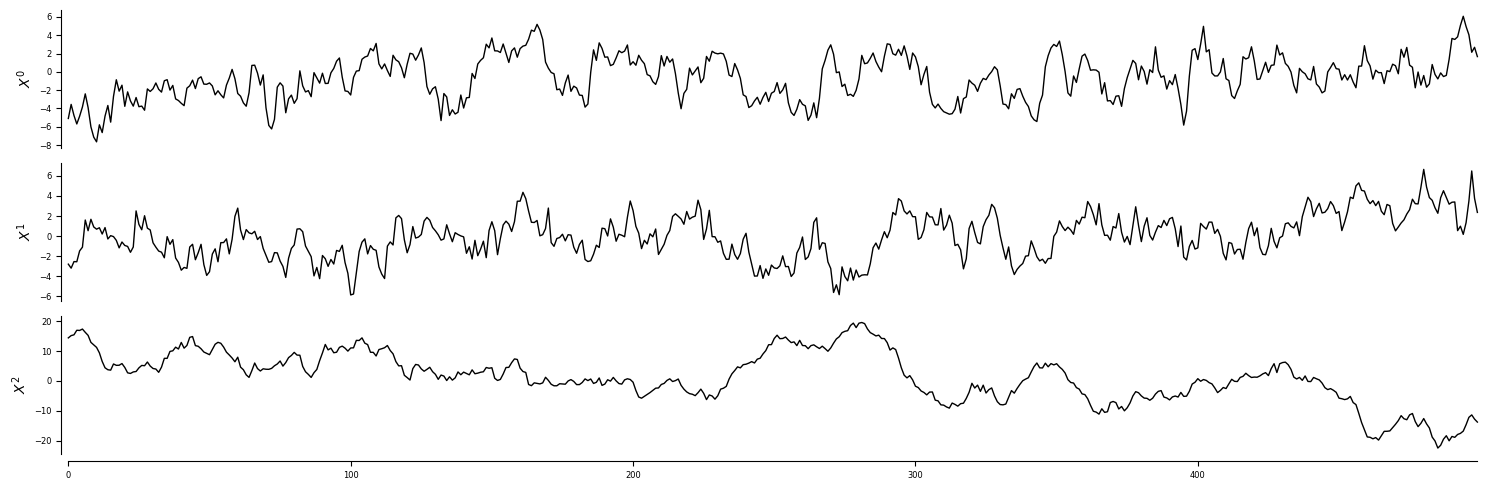

In [3]:
tp.plot_timeseries(dataframe, figsize=(15, 5));
plt.show()

### 3.3 Exploration: Bivariate lagged conditional independence

In order to obtain an idea which `tau_max` to choose one may run the `run_bivci` function, which implements a bivariate lagged conditional independence test (similar to bivariate Granger causality, but lag-specific). This function is implemented by the `PCMCI` class.

In [4]:
# Create a (conditional) independence test object
# Here, the partial correlation test is used
parcorr = ParCorr(significance='analytic')

# Create a PCMCI object, passing the the dataframe and (conditional)
# independence test object.
pcmci = PCMCI(dataframe=dataframe, 
              cond_ind_test=parcorr,
              verbosity=1)


##
## Running Tigramite BivCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 20


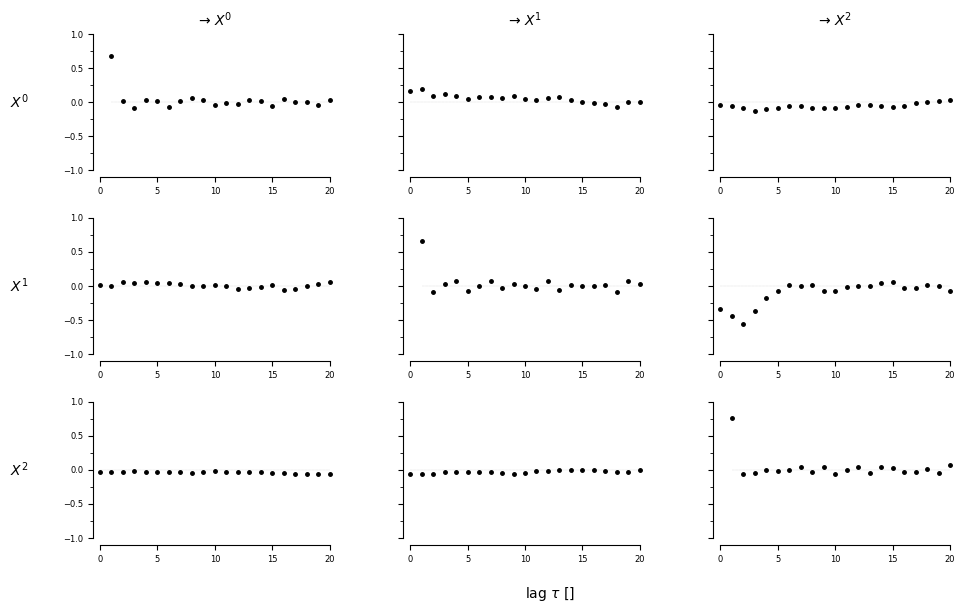

In [5]:
# Run the `PCMCI.run_bivci` function
correlations = pcmci.run_bivci(tau_max=20, val_only=True)['val_matrix']

# Plot the results
setup_args = {'var_names':var_names,
              'figsize':(10, 6),
              'x_base':5,
              'y_base':.5}
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, 
                                   setup_args=setup_args)

### 3.4 Application of LPCMCI

Based on the results of `run_bivci`, we choose to apply LPCMCI with `tau_max = 5` since after that lag, the lag functions decay to zero. Note that this is only a heuristic. In addition, you may also check scatter plots as done in the PCMCI tutorial in order to choose an appropriate conditional independence test. We further choose `pc_alpha = 0.01` and apart from that do not modify the default hyperparameter settings.

In [6]:
# Create a LPCMCI object, passing the dataframe and (conditional)
# independence test objects.
# parcorr = ParCorr(significance='analytic')
lpcmci = LPCMCI(dataframe=dataframe, 
                cond_ind_test=parcorr,
                verbosity=1)

# Define the analysis parameters.
tau_max = 5
pc_alpha = 0.01

# Run LPCMCI
results = lpcmci.run_lpcmci(tau_max=tau_max,
                            pc_alpha=pc_alpha)


Starting preliminary phase  1

Starting test phase

p = 0

Test phase complete
p = 1
(0,-5) independent (0, 0) given ((0, -1),) union set()
(0,-4) independent (0, 0) given ((0, -1),) union set()
(0,-3) independent (0, 0) given ((0, -1),) union set()
(0,-2) independent (0, 0) given ((0, -1),) union set()
(1,-5) independent (1, 0) given ((1, -1),) union set()
(1,-4) independent (1, 0) given ((1, -1),) union set()
(1,-3) independent (1, 0) given ((1, -1),) union set()
(1,-2) independent (1, 0) given ((1, -1),) union set()
Writing:   (0,-5) oL> (0, 0) ==> (0,-5)     (0, 0) 
Writing:   (0,-4) oL> (0, 0) ==> (0,-4)     (0, 0) 
Writing:   (0,-3) oL> (0, 0) ==> (0,-3)     (0, 0) 
Writing:   (0,-2) oL> (0, 0) ==> (0,-2)     (0, 0) 
Writing:   (1,-5) oL> (1, 0) ==> (1,-5)     (1, 0) 
Writing:   (1,-4) oL> (1, 0) ==> (1,-4)     (1, 0) 
Writing:   (1,-3) oL> (1, 0) ==> (1,-3)     (1, 0) 
Writing:   (1,-2) oL> (1, 0) ==> (1,-2)     (1, 0) 
(0, 0) independent (1, 0) given ((0, -1),) union set()
(0,

(2,-4) independent (0, 0) given () union {(0, -1), (2, -5)}
(2,-4) independent (1, 0) given () union {(1, -1), (2, -5)}
Writing:   (1,-4) oL> (0, 0) ==> (1,-4)     (0, 0) 
Writing:   (2,-4) oL> (0, 0) ==> (2,-4)     (0, 0) 
Writing:   (0,-4) oL> (1, 0) ==> (0,-4)     (1, 0) 
Writing:   (2,-4) oL> (1, 0) ==> (2,-4)     (1, 0) 
Writing:   (0,-4) oL> (2, 0) ==> (0,-4)     (2, 0) 
Writing:   (1,-4) oL> (2, 0) ==> (1,-4)     (2, 0) 
(0,-5) independent (1, 0) given () union {(1, -1)}
(0,-5) independent (2, 0) given () union {(2, -1), (1, -2)}
(1,-5) independent (0, 0) given () union {(0, -1)}
(1,-5) independent (2, 0) given () union {(2, -1), (1, -2)}
(2,-5) independent (0, 0) given () union {(0, -1)}
(2,-5) independent (1, 0) given () union {(1, -1)}
Writing:   (1,-5) oL> (0, 0) ==> (1,-5)     (0, 0) 
Writing:   (2,-5) oL> (0, 0) ==> (2,-5)     (0, 0) 
Writing:   (0,-5) oL> (1, 0) ==> (0,-5)     (1, 0) 
Writing:   (2,-5) oL> (1, 0) ==> (2,-5)     (1, 0) 
Writing:   (0,-5) oL> (2, 0) ==> (0,

Next, we use the function `tp.plot_time_series_graph` to plot the learned time series DPAG (in these plots only the time window $[t-\tau_{\max}, t]$ is shown). In the present case the learned graph exactly agrees with the true time series DPAG $\mathcal{P}^5(\mathcal{G})$. Note, in particular, that LPCMCI has correctly identified $X^1_{t-1}$ and $X^2_t$ to be correlated due to an unobserved variable. The edges are colored according to the test statistic values returned by `LPCMCI.run_lpcmci`, i.e., the value of `val_matrix[i, j, tau]` determines the color of the edge between $X^i_{t-\tau}$ and $X^j_t$ (provided this edge exists, i.e., provided `graph[i, j, tau]` is not the empty string) according to the color scale at the bottom.

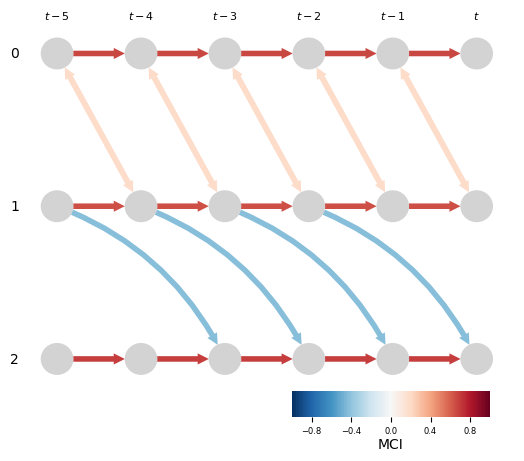

In [7]:
# Plot the learned time series DPAG
tp.plot_time_series_graph(graph=results['graph'],
                          val_matrix=results['val_matrix'])
plt.show()

Another visualization is offered by the function `tp.plot_graph`, which as compared to `tp.plot_time_series_graph` intuitively speaking collapses the graph along the time dimension and thus contains a single node $i$ per observed component time series $X^i$. Among all edges between $X^i_{t-\tau}$ and $X^j_t$ with $\tau > 0$ that are in `graph`, the strongest one (where *strongest* is measured according to the absolute values of the test statistic values in `val_matrix`) is drawn between nodes $i$ and $j$ in a curved way and the small numbers above this edge list the lags of all these edges in order of their strength. Equivalently for all edges between $X^j_{t-\tau}$ and $X^i_t$ with $\tau > 0$. Contemporaneous edges are drawn in a straight (uncurved) way. The color of node $i$ denotes the maximum of the absolute value of `val_matrix[i, i, tau]` across all $1 \leq \tau \leq \tau_{\max}$.

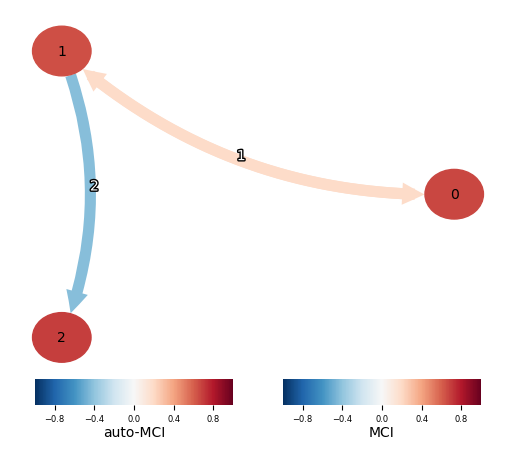

In [8]:
# Plot the learned time series DPAG
tp.plot_graph(graph=results['graph'],
              val_matrix=results['val_matrix'])
plt.show()

For reference we here print out the values returned by the above application of `LPCMCI.run_lpcmci`.

In [9]:
print("Graph:\n", results['graph'])
print("\n Maximum p-values:\n", results['p_matrix'])
print("\n Associated test statistic values:\n", results['val_matrix'])

Graph:
 [[['' '-->' '' '' '' '']
  ['' '<->' '' '' '' '']
  ['' '' '' '' '' '']]

 [['' '' '' '' '' '']
  ['' '-->' '' '' '' '']
  ['' '' '-->' '' '' '']]

 [['' '' '' '' '' '']
  ['' '' '' '' '' '']
  ['' '-->' '' '' '' '']]]

 Maximum p-values:
 [[[0.00000000e+00 3.27587534e-64 6.51860767e-01 1.66931805e-01
   3.04058029e-01 2.69057386e-01]
  [4.98048580e-01 1.89520062e-05 8.15648082e-01 3.92853908e-01
   1.53679037e-01 1.45390533e-01]
  [9.95865102e-01 8.18453518e-01 2.04903656e-01 9.50878017e-01
   8.78253227e-01 6.62506933e-01]]

 [[4.98048580e-01 3.32516878e-01 9.33958496e-01 4.00491160e-01
   3.51910395e-01 6.25033647e-01]
  [0.00000000e+00 4.98133288e-59 7.65326735e-02 9.28068282e-01
   6.83165836e-02 1.95806341e-01]
  [6.17173412e-01 6.30053996e-01 3.96190603e-23 6.53400606e-01
   8.99607220e-01 2.03196810e-01]]

 [[9.95865102e-01 5.72581051e-01 4.83792985e-01 7.79203277e-02
   4.34900724e-01 5.91366004e-01]
  [6.17173412e-01 4.41473095e-01 1.86116114e-02 3.31452183e-01
   5.0

### 3.5 A different choice of $\tau_{\max}$

The below code runs LPCMCI with $\tau_{max} = 2$ on the same data. The learned graph perfectly agrees with the true time series DPAG $\mathcal{P}^2(\mathcal{G})$ shown above in section 1.3. We note that $\mathcal{P}^2(\mathcal{G})$ differs from $\mathcal{P}^5(\mathcal{G})$ in that in $\mathcal{P}^2(\mathcal{G})$ there is the edge $X^2_{t-2} {\circ\!{\rightarrow}} X^3_t$ while in $\mathcal{P}^5(\mathcal{G})$ there is the edge $X^2_{t-2} {\rightarrow} X^3_t$. This is NOT a finite-sample effect due to erroneous test decisions but rather another example of the fact that $\mathcal{P}^{\tau_{\max}}(\mathcal{G})$ can depend on $\tau_{\max}$.

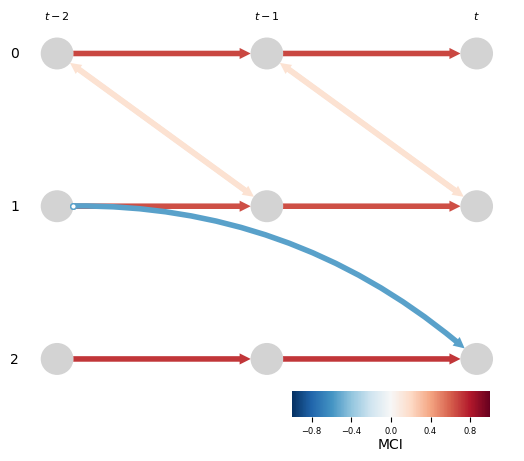

In [10]:
# Create a LPCMCI object, passing the dataframe and (conditional)
# independence test objects.
# parcorr = ParCorr(significance='analytic')
lpcmci = LPCMCI(dataframe=dataframe, 
                cond_ind_test=parcorr,
                verbosity=0)

# Define the analysis parameters.
tau_max = 2
pc_alpha = 0.01

# Run LPCMCI
results = lpcmci.run_lpcmci(tau_max=tau_max,
                            pc_alpha=pc_alpha)

# Plot the learned time series DPAG
tp.plot_time_series_graph(graph=results['graph'],
                          val_matrix=results['val_matrix'])
plt.show()

### 3.6 Comparison with PCMCIplus

The PCMCIplus algorithm assumes the absence of unobserved variables. While this assumption is violated in the present example, let us see what happens when we apply it to the data.

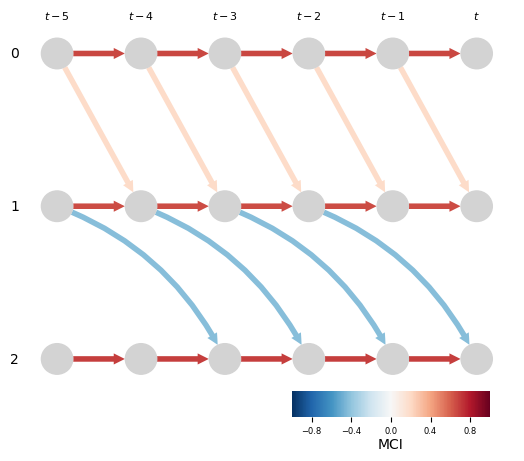

In [11]:
# Create a PCMCI object, passing the dataframe and (conditional)
# independence test objects.
# parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(dataframe=dataframe, 
              cond_ind_test=parcorr,
              verbosity=0)

# Define the analysis parameters.
tau_max = 5
pc_alpha = 0.01

# Run LPCMCI
results = pcmci.run_pcmciplus(tau_max=tau_max,
                              pc_alpha=pc_alpha)

# Plot the learned time series DPAG
tp.plot_time_series_graph(graph=results['graph'],
                          val_matrix=results['val_matrix'])
plt.show()

We see that PCMCIplus infers the correct adjacencies and for most edges also the correct edge type. However, instead of $X^0_{t-1} {\leftrightarrow} X^1_t$ it wrongly infers $X^0_{t-1} {\rightarrow} X^1_t$, which wrongly claims a causal influence of $X^0_{t-1}$ on $X^1_t$. This is an immediate implication of the assumption of no unobserved variables: Without unobserved variables the only possible edge orientations are $X^0_{t-1} {\rightarrow} X^1_t$ and $X^0_{t-1} {\leftarrow} X^1_t$, the latter of which is excluded because there is no causal influence backwards in time.

### 3.7 On the importance of preliminary phases

In subsection 2.4 we have introduced and discussed the importance of LPCMCI's preliminary phases, i.e., of step 2. of the algorithm. By default LPCMCI uses `n_preliminary_iterations = 1` ($k=1$ in step 2. of the algorithm), i.e., by default runs one preliminary phase. As we have seen above, this led to good results for the present example. We here show the results of running LPCMCI WITHOUT preliminary phases, i.e., with `n_preliminary_iterations = 0` for both `tau_max = 5` and `tau_max = 2`.

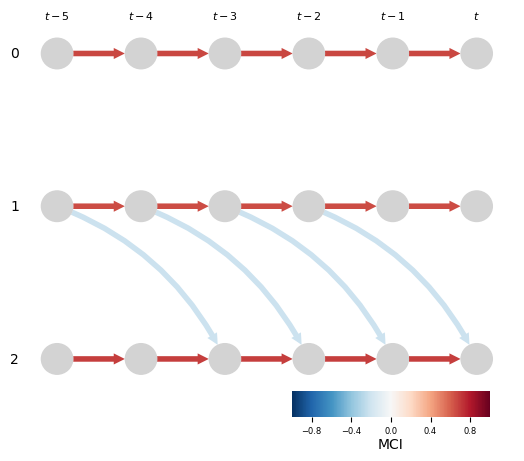

In [12]:
# Create a LPCMCI object, passing the dataframe and (conditional)
# independence test objects.
# parcorr = ParCorr(significance='analytic')
lpcmci = LPCMCI(dataframe=dataframe, 
                cond_ind_test=parcorr,
                verbosity=0)

# Define the analysis parameters.
tau_max = 5
pc_alpha = 0.01
n_preliminary_iterations = 0

# Run LPCMCI
results = lpcmci.run_lpcmci(tau_max=tau_max,
                            pc_alpha=pc_alpha,
                            n_preliminary_iterations=n_preliminary_iterations)

# Plot the learned time series DPAG
tp.plot_time_series_graph(graph=results['graph'],
                          val_matrix=results['val_matrix'])
plt.show()

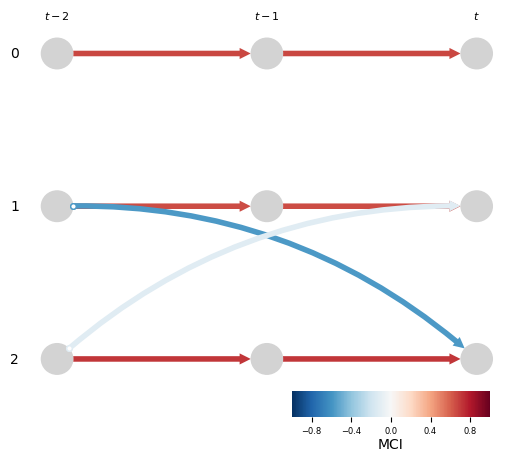

In [13]:
# Create a LPCMCI object, passing the dataframe and (conditional)
# independence test objects.
# parcorr = ParCorr(significance='analytic')
lpcmci = LPCMCI(dataframe=dataframe, 
                cond_ind_test=parcorr,
                verbosity=0)

# Define the analysis parameters.
tau_max = 2
pc_alpha = 0.01
n_preliminary_iterations = 0

# Run LPCMCI
results = lpcmci.run_lpcmci(tau_max=tau_max,
                            pc_alpha=pc_alpha,
                            n_preliminary_iterations=n_preliminary_iterations)

# Plot the learned time series DPAG
tp.plot_time_series_graph(graph=results['graph'],
                          val_matrix=results['val_matrix'])
plt.show()

We see that, unlike with the default setting, the algorithm fails to detect the edge $X^0_{t-1} {\leftrightarrow} X^1_t$. This is a manifestion of what has been discussed in subsection 2.3: A low effect size due to autocorrelation of the time series. With the default settings, where `n_preliminary_iterations = 1`, this problem is addressed by restoring all removed edges after the preliminary phase and then working with larger default conditioning sets $\mathcal{S}_{def}(X^i_{t-\tau}, X^j_t)$ in the final ancestral phase (step 3.) of the algorithm.

For those interested in validating this point in more detail:\
The edge between $X^0_{t-1}$ and $X^1_t$ is removed because the (conditional) independence test wrongly judges $X^0_{t-1}$ and $X^1_t$ to be independent conditional on $X^0_{t-2}$. To see this set `verbosity = 1` when creating the LPCMCI object in the previous two cells and search for the line `(0,-1) independent (1, 0) given ((0, -2),) union set()` in the verbose output, or set ``verbosity = 2`` and search for ``ANC(Y):    (0, -1) _|_ (1, 0)  |  S_def = , S_pc = (0, -2): val = 0.10 / pval =  0.0287`` (here, ``S_pc`` refers to the standard conditioning set $\mathcal{S}$ and ``S_def`` to the default conditions $\mathcal{S}_{def}$). Then set `verbosity = 2` in the default applications of LPCMCI in subsections 3.4 and 3.5 above and see that the same happens in the preliminary phases of these runs. However, in these cases the algorithm restores this edge before moving to the final ancestral phase while it remembers that $X^0_{t-2}$ is a causal ancestor of $X^0_{t-1}$ and that $X^1_{t-1}$ is a causal ancestor of $X^1_{t}$. The final ancestral phase therefore uses $\mathcal{S}_{def}(X^0_{t-1}, X^0_t) = \{X^0_{t-2}, X^1_{t-1}\}$ and never tests whether $X^0_{t-1}$ and $X^1_t$ are conditionally independent given $X^0_{t-2}$. Indeed, search for ``ANC(Y):    (0, -1) _|_ (1, 0)  |  S_def = (0, -2) (1, -1), S_pc = : val = 0.19 / pval =  0.0000`` in the verbose output.

For `tau_max = 2` it is further wrongly inferred that $X^2_{t-2}$ and $X^1_t$ are adjacent.

## 4. Incorporating background knowledge

In some cases, you might have a priori knowledge about the existence vs absence of certain links and/or about the orientation of certain links. You can inform LPCMCI about this background knowledge by means of the optional keyword argument `link_assumptions` that is passed to `LPCMCI.run_lpcmci`. The default value of `link_assumptions` is `None`.

The value passed to `link_assumptions` needs to be a two-level nested dictionary of the form `{j: {(i, lag_i): link, ...}, ...}`, where `link` is a string that specifies your a priori knowledge about the link between the variables $X^i_{t+lag_i}$ and $X^j_t$ (with $lag_i < 0$) according to the following rules:

- `link_assumptions[j][(i, lag_i)] = '-?>'`: $X^i_{t+lag_i}$ is an ancestor of $X^j_t$.
- `link_assumptions[j][(i, lag_i)] = '-->'`: $X^i_{t+lag_i}$ is an ancestor of $X^j_t$, and there is a link between $X^i_{t+lag_i}$ and $X^j_t$.
- `link_assumptions[j][(i, lag_i)] = '<?-'`: Only allowed for $lag_i = 0$. $X^j_t$ is an ancestor of $X^i_t$.
- `link_assumptions[j][(i, lag_i)] = '<--'`: Only allowed for $lag_i = 0$. $X^j_t$ is an ancestor of $X^i_t$, and there is a link between $X^i_t$ and $X^j_t$.
- `link_assumptions[j][(i, lag_i)] = '<?>'`: Neither $X^i_{t+lag_i}$ is an ancestor of $X^j_t$ nor the other way around.
- `link_assumptions[j][(i, lag_i)] = '<->'`: Neither $X^i_{t+lag_i}$ is an ancestor of $X^j_t$ nor the other way around, and there is a link between $X^i_{t+lag_i}$ and $X^j_t$.
- `link_assumptions[j][(i, lag_i)] = 'o?>'`: $X^j_t$ is not an ancestor of $X^i_{t+lag_i}$ (for $lag_i < 0$ this background knowledge is for the default settings of self.run_lpcmci() imposed automatically).
- `link_assumptions[j][(i, lag_i)] = 'o->'`: $X^j_t$ is not an ancestor of $X^i_{t+lag_i}$, and there is a link between $X^i_{t+lag_i}$ and $X^j_t$.
- `link_assumptions[j][(i, lag_i)] = '<?o'`: Only allowed for $lag_i = 0$. $X^i_t$ is not an ancestor of $X^j_t$.
- `link_assumptions[j][(i, lag_i)] = '<-o'`: Only allowed for $lag_i = 0$. $X^i_t$ is not an ancestor of $X^j_t$, and there is a link between $X^i_t$ and $X^j_t$.
- `link_assumptions[j][(i, lag_i)] = 'o-o'`: Only allowed for $lag_i = 0$. There is a link between $X^i_t$ and $X^j_t$.
- `link_assumptions[j][(i, lag_i)] = 'o?o'`: Only allowed for $lag_i = 0$. No claim is made.
- `link_assumptions[j][(i, lag_i)] = ''`: There is no link between $X^i_{t+lag_i}$ and $X^j_t$.
- If `link_assumptions` is not `None` and `link_assumptions[j]` or `link_assumptions[j][(i, lag_i)]` does not exist, then it is assumed that there is no link between $X^i_{t+lag_i}$ and $X^j_t$ (so equivalent to `link_assumptions[j][(i, lag_i)] = ''`).

The information contained in `link_assumptions` must be consistent in all of the following three regards:
- The $lag_i = 0$ zero links must be symmetric. For example, if `link_assumptions[j][(i, 0)] = '-?>'`, then it is necessary that `link_assumptions[i][(j, 0)] = '<?-'`.
- The ancestorships must not specify a cyclic causal relationships. That is, if the ancestorships specify that $X^i_{t+lag_i}$ is an ancestor of $X^j_t$, then `link_assumptions[j][(i, lag_i)]` must be neither of `'<?-`', `'<--`'.
- If the ancestorships specify that $X^i_{t+lag_i}$ is an ancestor of $X^j_t$, then `link_assumptions[j](i, lag_i)]` must be neither of `'<?>`', `'<->`', `'<?o`', `'<-o`'.

These requirements are checked automatically. If the passed value violates these requirements, then error messages are raised that explain the violation in detail and help you to specify a valid value.

Moreover, both $i$ and $j$ in `link_assumptions[j][(i, lag_i)]` must be within $[0, \ldots, N-1]$, where $N$ is the number of component time series, and $lag_i$ must be within $[-\tau_{max}, \tau_{\min}]$. Lastly, `link_assumptions[j]` must not contain the key `(j, 0)` because this key would refer to a link between the variable $X^j_t$ and itself.

Consider, for example, a case with $N=2$ component time series and $\tau_{max} = 1$ and $\tau_{min} = 0$. Say you would like to specfiy that $X^1_{t-1} \rightarrow X^0_t$ exists for sure and that $X^0_t$ does not cause $X^1_t$. Then, `link_assumptions` needs to look as follows:

`link_assumptions = {0: {(0, -1): 'o?>', (1, 0): 'o?>', (1, -1): '-->'}, 1: {(1, -1): 'o?>', (0, 0): '<?o', (0, -1): 'o?>'}}`

**Importantly**, keep in mind the last bullet point in the above explanation of what entries in `link_assumptions` mean: If `link_assumptions` does not take its default value `None` and `link_assumptions[j][(i, lag_i)]` does not exist, then this combination of facts is equivalent to specifying `link_assumptions[j][(i, lag_i)] = ''`.

There might be cases in which you have background knowledge on only a small number of the possible links and it is cumbersome to build the full nested dictionary, where absence of background knowledge needs to be specified by `link_assumptions[j][(i, lag_i)] = 'o?>` for $lag_i < 0$ and by `link_assumptions[j][(i, 0)] = 'o?o'` for $lag_i = 0$. In such cases, you can use the following convenience functions in your code or notebook.

In [14]:
def build_link_assumptions(link_assumptions_absent_link_means_no_knowledge,
                           n_component_time_series,
                           tau_max,
                           tau_min=0):

    out = {j: {(i, -tau_i): ("o?>" if tau_i > 0 else "o?o")
         for i in range(n_component_time_series) for tau_i in range(tau_min, tau_max+1)
         if (tau_i > 0 or i != j)} for j in range(n_component_time_series)}

    for j, links_j in link_assumptions_absent_link_means_no_knowledge.items():
        for (i, lag_i), link_ij in links_j.items():
            if link_ij == "": 
                del out[j][(i, lag_i)]
            else:
                out[j][(i, lag_i)] = link_ij
    return out

Returning to the previous example, you can specify

`link_assumptions_absent_link_means_no_knowledge = {0: {(1, 0): 'o?>', (1, -1): '-->'}, 1: {(0, 0): '<?o'}}`

and the build `link_assumptions` as

`link_assumptions = build_link_assumptions(link_assumptions_absent_link_means_no_knowledge, 2, 1)`.

## References

[1] Pearl, J. (2009). *Causality: Models, Reasoning, and Inference*. Cambridge University Press, Cambridge, UK, 2nd edition.\
[2] Peters, J., Janzing, D., and Schölkopf, B. (2017). *Elements of Causal Inference: Foundations and Learning Algorithms*. MIT Press, Cambridge, MA, USA.\
[3] Richardson, T. and Spirtes, P. (2002). Ancestral graph markov models. *The Annals of Statistics*, 30:962–1030.\
[4] Zhang, J. (2008a). Causal reasoning with ancestral graphs. *Journal of Machine Learning Research*, 9:1437–1474.\
[5] Ali, R. A., Richardson, T. S., and Spirtes, P. (2009). Markov equivalence for ancestral graphs. *The Annals of Statistics*, 37(5B):2808–2837.\
[6] Zhang, J. (2008b). On the completeness of orientation rules for causal discovery in the presence of latent confounders and selection bias. *Artificial Intelligence*, 172:1873–1896.\
[7] Spirtes, P., Meek, C., and Richardson, T. (1995). Causal Inference in the Presence of Latent Variables and Selection Bias. In Besnard, P. and Hanks, S., editors, *Proceedings of the Eleventh Conference on Uncertainty in Artificial Intelligence*, UAI’95, page 499–506, San Francisco, CA, USA. Morgan Kaufmann Publishers Inc.\
[8] Spirtes, P., Glymour, C., and Scheines, R. (2000). *Causation, Prediction, and Search*. MIT Press, Cambridge, MA, USA.\
[9] Runge, J., Nowack, P., Kretschmer, M., Flaxman, S., and Sejdinovic, D. (2019). Detecting and quantifying causal associations in large nonlinear time series datasets. *Science Advances*, 5:eaau4996.\
[10] Runge, J. (2020). Discovering contemporaneous and lagged causal relations in autocorrelated nonlinear time series datasets. In Sontag, D. and Peters, J., editors, *Proceedings of the 36th Conference on Uncertainty in Artificial Intelligence*, UAI 2020, Toronto, Canada, 2019. AUAI Press.\
[11] Spirtes, P. and Glymour, C. (1991). An Algorithm for Fast Recovery of Sparse Causal Graphs. *Social Science Computer Review*, 9:62–72.